In [3]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

# Data import & prep

In [4]:
# read CSV's to dataframes
df_base = pd.read_csv("/Users/jeremyvanvalkenburg/Repositories/datasets/export_base.csv")
df_p2p = pd.read_csv("/Users/jeremyvanvalkenburg/Repositories/datasets/export_p2p.csv")

# filter out entries w/out any visitors
df_base = df_base[(df_base.visits!=0)&(df_base.visits!=0)]
df_p2p = df_p2p[df_p2p.base.isin(df_base.id.values.tolist())]

# merge the dataframes and generate donation conversion column
df = pd.merge(df_base, df_p2p, left_on='id', right_on='base')
df['donation_conversion'] = df['don_count'] / df['visits']

In [5]:
ftrs = ['class_count', 'cat_count', 'promo_count', 'rest_count', 'amt_count', 'ded_count', 
'fields', 'opt_fields', 'req_fields', 'allows_reg_ind', 'allows_teams', 'allows_reg_team_create', 
'allows_reg_team_join', 'allows_opt_reg_donation', 'allows_pfp_off_don', 'allows_tfp_off_don']

X_train, X_test, y_train, y_test = train_test_split(df[ftrs], df['donation_conversion'], test_size=0.25)

# Donation Conversion Modeling

## GBR

Based upon the exploration and a quick run of simple feature engineering, I suspect there is not a strong linear relationship here as the Linear Regression is performing quite poorly. As such, I'm going to start with GBR with a little feature selection based upon the feature importances revealed in the quick model generated previously. __allows_sub_reg_pfp__, __allows_sub_reg__, and __allows_other_don_amt__ were identified with 0 impact so they were removed from the feature list.

Going to start with all features in a rather small predictor (100, default settings).

In [6]:
gbr_1 = GradientBoostingRegressor()
gbr_1.fit(X_train, y_train)
y_pred = gbr_1.predict(X_test)
print("Prediction error: {}".format((y_pred-y_test).mean()))
print("R^2: {}".format(gbr_1.score(X_test, y_test)))

print("Feature importances:")
coef_dict = {}
for coef, feat in zip(gbr_1.feature_importances_, ftrs):
    coef_dict[feat] = abs(coef)
import operator
coef_dict_sorted = sorted(coef_dict.items(), key=operator.itemgetter(1))
for c in coef_dict_sorted:
    print("\t{}: {}".format(c[0], c[1]))

Prediction error: -9.83832103782e-05
R^2: 0.0406193427449
Feature importances:
	rest_count: 0.00811425579036
	allows_reg_team_create: 0.0115209098783
	allows_pfp_off_don: 0.0135028751141
	allows_opt_reg_donation: 0.0142715677296
	allows_tfp_off_don: 0.0156289206
	allows_teams: 0.0209805259559
	allows_reg_team_join: 0.021051503493
	fields: 0.0429058501971
	allows_reg_ind: 0.0471288866505
	opt_fields: 0.0512061970604
	ded_count: 0.0673532045676
	promo_count: 0.0829686047363
	req_fields: 0.111797954439
	amt_count: 0.121103072779
	class_count: 0.135944778663
	cat_count: 0.234520892345


This reduced the prediction error and increased R^2 over the default model from data exploration, but still rather insufficient. Let's look at an iteration over tree counts to see if manipulating the architecture of the GBR has any significant impact on performance.

In [7]:
for n in [50, 100, 250, 500, 750, 1000]:
    gbr = GradientBoostingRegressor(n_estimators=n)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    print("GBR with {} estimators:".format(n))
    print("\tPrediction error: {}".format((y_pred-y_test).mean()))
    print("\tR^2: {}".format(gbr.score(X_test, y_test)))

GBR with 50 estimators:
	Prediction error: -9.8515292837e-05
	R^2: 0.0317123896226
GBR with 100 estimators:
	Prediction error: -9.83832103781e-05
	R^2: 0.0406193427449
GBR with 250 estimators:
	Prediction error: -0.000111273975765
	R^2: 0.0673234443991
GBR with 500 estimators:
	Prediction error: -0.000130378879275
	R^2: 0.0784927072619
GBR with 750 estimators:
	Prediction error: -0.000134376036426
	R^2: 0.0815268134102
GBR with 1000 estimators:
	Prediction error: -0.00013606244598
	R^2: 0.0833220722616


Looks like every 250 estimators added is buying us ~2% R^2 improvement until we 750 where it's tapering off. The diminishing returns here means we're not likely to see meaningful impovement beyond 750.

## Random Forest

In [8]:
for n in [50, 100, 250, 500, 750, 1000]:
    rfr = RandomForestRegressor(n_estimators=n)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    print("Random Forest with {} estimators".format(n))
    print("\tPrediction error: {}".format((y_pred-y_test).mean()))
    print("\tR^2: {}".format(rfr.score(X_test, y_test)))

Random Forest with 50 estimators
	Prediction error: -0.000144711848597
	R^2: 0.0968369127802
Random Forest with 100 estimators
	Prediction error: -0.00013253147604
	R^2: 0.0963789124375
Random Forest with 250 estimators
	Prediction error: -0.000133898682628
	R^2: 0.096109788289
Random Forest with 500 estimators
	Prediction error: -0.000128378875579
	R^2: 0.0964633930239
Random Forest with 750 estimators
	Prediction error: -0.000136444169531
	R^2: 0.0962812463677
Random Forest with 1000 estimators
	Prediction error: -0.000133303443807
	R^2: 0.0963798768636


In [9]:
ftrs = ['class_count', 'cat_count', 'promo_count', 'rest_count', 'amt_count', 'ded_count', 
'fields', 'opt_fields', 'req_fields', 'allows_reg_ind', 'allows_teams', 'allows_reg_team_create', 
'allows_reg_team_join', 'allows_opt_reg_donation', 'allows_pfp_off_don', 'allows_tfp_off_don']

mse = []
r2 = []
vexp = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(df[ftrs], df['donation_conversion'], test_size=0.25)
    
    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    mse.append(metrics.mean_squared_error(y_test, y_pred))
    r2.append(metrics.r2_score(y_test, y_pred))
    vexp.append(metrics.explained_variance_score(y_test, y_pred))

print("MSE: {}".format(np.mean(mse)))
print("R2: {}".format(np.mean(r2)))
print("Variance explained: {}".format(np.mean(vexp)))

MSE: 0.0030492217314
R2: 0.098212609006
Variance explained: 0.0982356608288


In [10]:
for i in range(len(X_test.columns)):
    print("|{}| {}|".format(X_test.columns[i], rfr.feature_importances_[i]))

|class_count| 0.10734711837|
|cat_count| 0.193226905184|
|promo_count| 0.0988603133489|
|rest_count| 0.00209334619665|
|amt_count| 0.174790732212|
|ded_count| 0.088887320327|
|fields| 0.0542160414709|
|opt_fields| 0.0399193787893|
|req_fields| 0.0411679667489|
|allows_reg_ind| 0.0474126622205|
|allows_teams| 0.0404007946759|
|allows_reg_team_create| 0.0293661689983|
|allows_reg_team_join| 0.0172743490634|
|allows_opt_reg_donation| 0.0381634793014|
|allows_pfp_off_don| 0.0127499432101|
|allows_tfp_off_don| 0.0141234798836|


Looks like Random Forest R^2 starts off much stronger than GBR but, while varying, doesn't appear to change significantly or predictably with the number of estimators.

## NN

Tree based and linear algorithms aren't doing spectacularly well so let's take a shot at NN's.

In [11]:
architectures = [(100,), (250,), (500,), (100,100,), (250,250,), (500,500,500,), (250,250,250,)]

for a in architectures:
    nn = MLPRegressor(hidden_layer_sizes=a)
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    print("NN with {} architecture".format(a))
    print("\tPrediction error: {}".format((y_pred-y_test).mean()))
    print("\tR^2: {}".format(nn.score(X_test, y_test)))

NN with (100,) architecture
	Prediction error: 0.000936484973379
	R^2: -0.0818819257306
NN with (250,) architecture
	Prediction error: -0.00196822039454
	R^2: 0.0161657044173
NN with (500,) architecture
	Prediction error: 0.00391520941286
	R^2: -0.00408103360161
NN with (100, 100) architecture
	Prediction error: -0.00109472647093
	R^2: 0.0538167175888
NN with (250, 250) architecture
	Prediction error: 0.000990064050761
	R^2: 0.0441069451999
NN with (500, 500, 500) architecture
	Prediction error: -0.00420646778281
	R^2: 0.0560815772751
NN with (250, 250, 250) architecture
	Prediction error: -0.000121098731817
	R^2: 0.0378590588138


NN is performing worse than both GBR and Random Forest, so this isn't going to help. Taking a swing something a little fancier...

In [12]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.reset_default_graph()
import tflearn
import numpy as np

In [13]:
import tensorflow as tf
tf.reset_default_graph()
import tflearn
import numpy as np

# Network building
net = tflearn.input_data([None, len(X_train.columns)])
net = tflearn.fully_connected(net, 64, activation='linear',
                                 regularizer='L2', weight_decay=0.0005)
# net = tflearn.embedding(net, input_dim=100, output_dim=128)
# net = tflearn.lstm(net, 128, dropout=0.1)
net = tflearn.fully_connected(net, 1, activation='linear')
net = tflearn.regression(net, optimizer=
	tflearn.optimizers.AdaGrad(learning_rate=0.01, initial_accumulator_value=0.01), 
	loss='mean_square', learning_rate=0.05)

# Training
model = tflearn.DNN(net, tensorboard_verbose=0, checkpoint_path='tmp/')
model.fit(np.array(X_train), np.reshape(np.array(y_train.values), (201072,1)), show_metric=True,
          n_epoch=10, batch_size=100)

score = model.evaluate(np.array(X_test), np.reshape(np.array(y_test.values), (len(y_test),1)))
print("Score: {}".format(score))

Training Step: 1654  | total loss: 0.00663 | time: 5.122s
| AdaGrad | epoch: 001 | loss: 0.00663 - binary_acc: 0.0284 -- iter: 165400/201072


KeyboardInterrupt: 

## LSTM outcome scores

- 1 epoch: 0.01023513965146813
- 10 epochs: 0.0090564573886205112, 0.016039030795161453, 0.011190021485063577
- 25 epochs: 0.0095189782764382915

# Visualization

In [14]:
import matplotlib.pyplot as plt

Original donation conversion for sample: 0.0294117647059


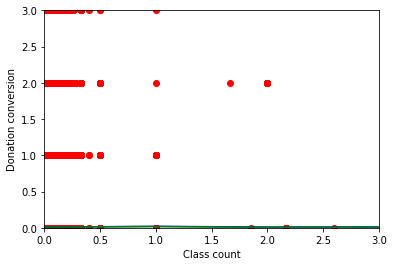

In [15]:
# scatter for all data
df_sample = df[ftrs+['donation_conversion']]
# group by class count to see mean don_count
grpd = df[['donation_conversion','class_count']].groupby('class_count').mean()
# run varying prediction to see how our model compares
y_preds = []
pred_sample = df[df.don_count>0][ftrs+['donation_conversion']].sample(1)
print("Original donation conversion for sample: {}".format(pred_sample['donation_conversion'].iloc[0]))
for n in range(100):
    pred_sample['class_count'] = n
    y_preds.append(rfr.predict(pred_sample.drop('donation_conversion', axis=1))[0])

plt.scatter(df_sample['donation_conversion'], df_sample['class_count'], color='r')
plt.plot(grpd.index, grpd['donation_conversion'], color='b')
plt.plot(range(100), y_preds, color="g")
plt.xlim(0,3)
plt.ylim(0,3)
plt.xlabel("Class count")
plt.ylabel("Donation conversion")
plt.show()

Original donation conversion for sample: 0.0172413793103


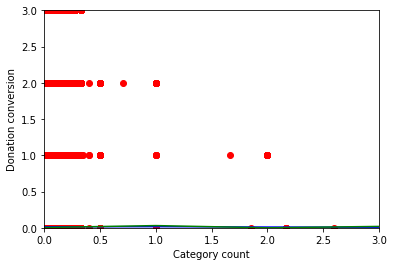

In [16]:
# scatter for all data
df_sample = df[ftrs+['donation_conversion']]
# group by class count to see mean don_count
grpd = df[['donation_conversion','cat_count']].groupby('cat_count').mean()
# run varying prediction to see how our model compares
y_preds = []
pred_sample = df[df.don_count>0][ftrs+['donation_conversion']].sample(1)
print("Original donation conversion for sample: {}".format(pred_sample['donation_conversion'].iloc[0]))
for n in range(100):
    pred_sample['cat_count'] = n
    y_preds.append(rfr.predict(pred_sample.drop('donation_conversion', axis=1))[0])

plt.scatter(df_sample['donation_conversion'], df_sample['cat_count'], color='r')
plt.plot(grpd.index, grpd['donation_conversion'], color='b')
plt.plot(range(100), y_preds, color="g")
plt.xlim(0,3)
plt.ylim(0, 3)
plt.xlabel("Category count")
plt.ylabel("Donation conversion")
plt.show()

Original donation conversion for sample: 0.0645161290323


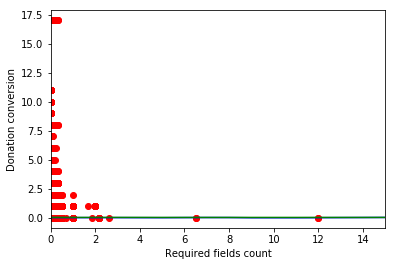

In [17]:
# scatter for all data
df_sample = df[ftrs+['donation_conversion']]
# group by class count to see mean don_count
grpd = df[['donation_conversion','req_fields']].groupby('req_fields').mean()
# run varying prediction to see how our model compares
y_preds = []
pred_sample = df[df.don_count>0][ftrs+['donation_conversion']].sample(1)
print("Original donation conversion for sample: {}".format(pred_sample['donation_conversion'].iloc[0]))
for n in range(100):
    pred_sample['req_fields'] = n
    y_preds.append(rfr.predict(pred_sample.drop('donation_conversion', axis=1))[0])

plt.scatter(df_sample['donation_conversion'], df_sample['req_fields'], color='r')
plt.plot(grpd.index, grpd['donation_conversion'], color='b')
plt.plot(range(100), y_preds, color="g")
plt.xlim(0,15)
plt.xlabel("Required fields count")
plt.ylabel("Donation conversion")
plt.show()

In [19]:
df.req_fields.value_counts().sort_index()

0     115691
1      73038
2      29833
3      17130
4      16330
5       3409
6       3498
7        196
8       4412
9        228
10      2402
11       859
17      1070
Name: req_fields, dtype: int64

In [25]:
df[['fields', 'req_fields', 'donation_conversion', 'amt_count', 'rest_count']].corr()

,fields,req_fields,donation_conversion,amt_count,rest_count
fields,1.000000,0.856274,-0.028306,0.072683,-0.001257
req_fields,0.856274,1.000000,-0.011564,0.110134,0.015903
donation_conversion,-0.028306,-0.011564,1.000000,-0.012636,0.002628
amt_count,0.072683,0.110134,-0.012636,1.000000,-0.036747
rest_count,-0.001257,0.015903,0.002628,-0.036747,1.000000


In [22]:
df.fields.value_counts().sort_index()

0     94115
1     59935
2     39650
3     24811
4     13617
5     12575
6      6173
7      1032
8      2475
9      2778
10     2713
11      787
12     1914
13     3442
16      402
21     1070
27      607
Name: fields, dtype: int64

In [24]:
df.amt_count.value_counts().sort_index()

0       2311
1        453
2          6
3       8858
4     127571
5      70206
6      34186
7      10965
8       5489
9       1765
10      3701
11      1338
12       851
26       396
Name: amt_count, dtype: int64

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# quick feature selected RF model that focuses on isolated donation settings
ftrs = ['fields', 'req_fields', 'amt_count', 'rest_count']
ftrs = ['fields', 'req_fields', 'amt_count', 'rest_count', 'cat_count', 'class_count']

r2 = []
mae = []
mse = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(df[ftrs], df['donation_conversion'], test_size=0.25)
    
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    # get metrics
    y_pred = rf.predict(X_test)
    
    r2.append(rf.score(X_test, y_test))
    mae.append(mean_absolute_error(y_pred, y_test))
    mse.append(mean_squared_error(y_pred, y_test))
    
print("RF w/ features: {}".format(', '.join(ftrs)))
print("\tMAE: {}".format(np.mean(mae)))
print("\tMSE: {}".format(np.mean(mse)))
print("\tR2: {}".format(np.mean(r2)))
print("\tFeature importances:")
for i in range(len(X_train.columns)):
    print("\t\t{}: {}".format(X_train.columns[i], rf.feature_importances_[i]))

RF w/ features: fields, req_fields, amt_count, rest_count, cat_count, class_count
	MAE: 0.0150268149541
	MSE: 0.00263096717535
	R2: 0.069196291761
	Feature importances:
		fields: 0.11715661813
		req_fields: 0.0906079303341
		amt_count: 0.313795840797
		rest_count: 0.00570044304856
		cat_count: 0.213633482757
		class_count: 0.259105684934


In [44]:
from sklearn.linear_model import LinearRegression

# quick feature selected RF model that focuses on isolated donation settings
ftrs = ['fields', 'req_fields', 'amt_count', 'rest_count']

r2 = []
mae = []
mse = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(df[ftrs], df['donation_conversion'], test_size=0.25)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # get metrics
    y_pred = lr.predict(X_test)
    
    r2.append(lr.score(X_test, y_test))
    mae.append(mean_absolute_error(y_pred, y_test))
    mse.append(mean_squared_error(y_pred, y_test))
    
print("LR w/ features: {}".format(', '.join(ftrs)))
print("\tMAE: {}".format(np.mean(mae)))
print("\tMSE: {}".format(np.mean(mse)))
print("\tR2: {}".format(np.mean(r2)))
print("\tFeature importances:")
for i in range(len(X_train.columns)):
    print("\t\t{}: {}".format(X_train.columns[i], lr.coef_[i]))

LR w/ features: fields, req_fields, amt_count, rest_count
	MAE: 0.0184813413575
	MSE: 0.00283511763202
	R2: 0.00215481794105
	Feature importances:
		fields: -0.00117347968678
		req_fields: 0.00124171739584
		amt_count: -0.000573953954922
		rest_count: 0.00012042684981
